In [82]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d

In [83]:
img_museum_amb = './data/museum/museum_ambient.png'
img_museum_flash = './data/museum/museum_flash.png'

img_museum_amb = cv2.imread(img_museum_amb,-1)[:,:,:3][:,:,::-1]
img_museum_flash = cv2.imread(img_museum_flash,-1)[:,:,:3][:,:,::-1]

img_museum_amb_norm = img_museum_amb / 255
img_museum_flash_norm = img_museum_flash / 255

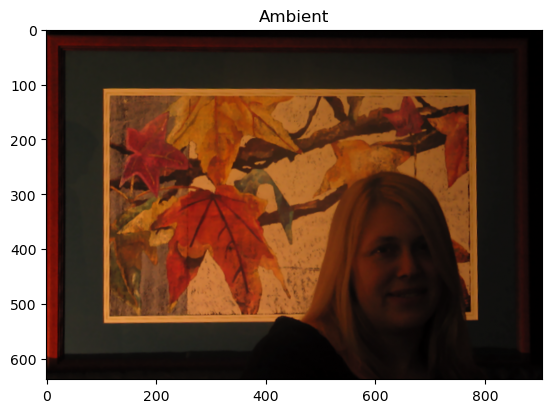

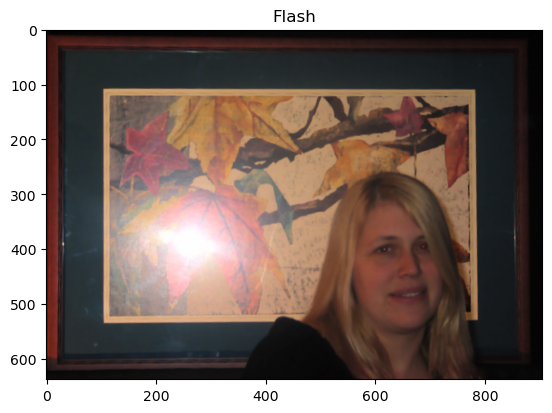

In [84]:
plt.imshow(img_museum_amb_norm)
plt.title('Ambient')
plt.show()

plt.imshow(img_museum_flash_norm)
plt.title('Flash')
plt.show()

# 2. Gradient-domain processing

## Differentiate and then re-integrate an image

In [85]:
def compute_gradient(img) : 

    # pad image with zeros    
    temp = img[:,:]
    
    row = np.zeros((1,img.shape[1]))
    col = np.zeros((img.shape[0]+2,1))
    
    temp2 = np.vstack((row,np.vstack((temp, row))))
    temp2 = np.hstack((col,np.hstack((temp2, col))))
    img = temp2 

    img_x = np.diff(img,n=1,axis=1) 
    img_y = np.diff(img,n=1,axis=0)  

    return img_x, img_y

def compute_laplacian(img) :     
    
    # laplacian kernel
    kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
    
    out = convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)
    
    return out 

channel = 2

def compute_div(u,v) :
    u_x = np.diff(u,n=1,axis=1)
    v_y = np.diff(v,n=1,axis=0)
    u_x, v_y = u_x[1:-1,:], v_y[:,1:-1]
    
    out = u_x + v_y
    
    return out
    

img_x_museum_amb_norm, img_y_museum_amb_norm  = compute_gradient(img_museum_amb_norm[:,:,channel])
laplacian_img_museum_amb_norm = compute_laplacian(img_museum_amb_norm[:,:,channel])
div_img_museum_amb_norm = compute_div(img_x_museum_amb_norm, img_y_museum_amb_norm )


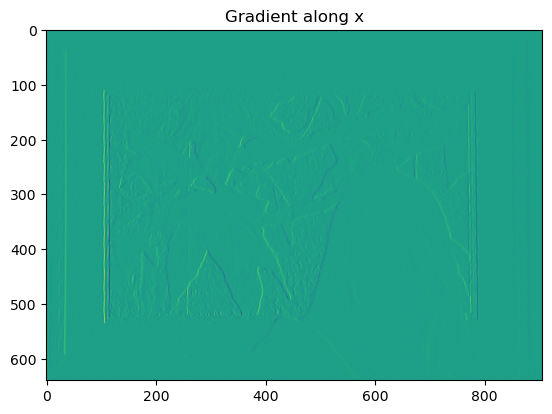

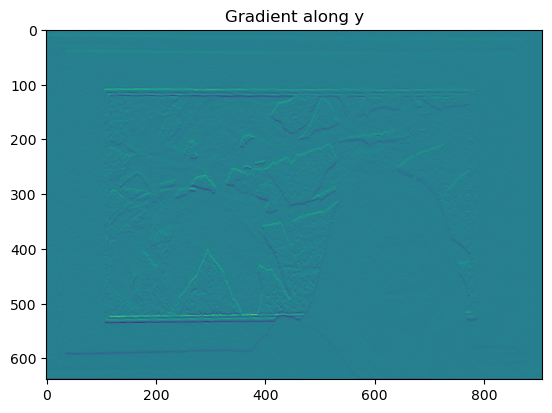

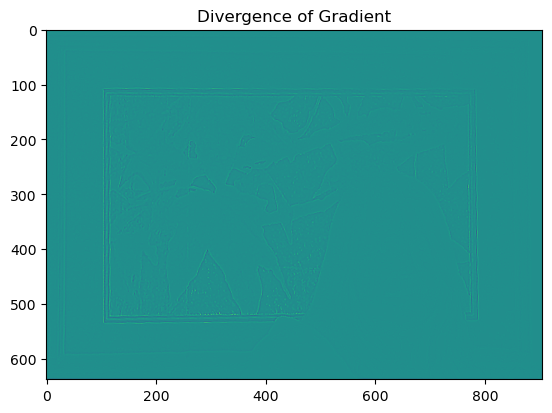

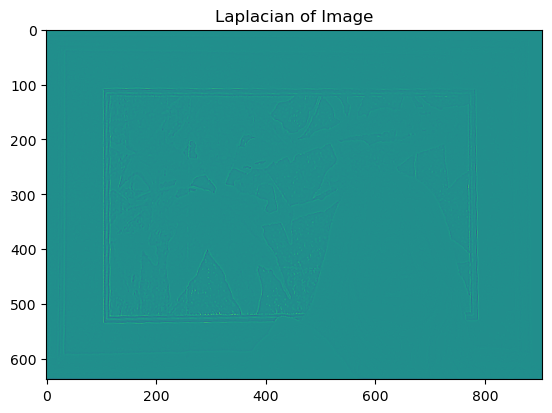

np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs) =  True


In [86]:
plt.imshow(img_x_museum_amb_norm)
plt.title("Gradient along x")
plt.show()

plt.imshow(img_y_museum_amb_norm)
plt.title("Gradient along y")
plt.show()

plt.imshow(div_img_museum_amb_norm)
plt.title("Divergence of Gradient")
plt.show()

plt.imshow(laplacian_img_museum_amb_norm)
plt.title("Laplacian of Image")
plt.show()

print("np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs) = ",np.allclose(div_img_museum_amb_norm, laplacian_img_museum_amb_norm))

In [120]:
plt.imsave('./outputs/img_x_museum_amb_norm.png',img_x_museum_amb_norm)
plt.imsave('./outputs/img_y_museum_amb_norm.png',img_y_museum_amb_norm)

In [109]:
def CGD(I_init, B, I_star_boundary, eps, N, D) :
    """
    Perform conjugate gradient descent to solve Poisson's equation.
    """
    
    I_star = B * I_init + (1-B) * I_star_boundary
    r = B * (D - compute_laplacian(I_star))
    d = r 
    delta_new = np.sum(r*r) # <r,r>
    
    n = 0
    while np.sqrt(np.sum(r*r)) > eps and n < N :
        
        q = compute_laplacian(d)
        eta = delta_new / np.sum(d*q)
        
        I_star = I_star + B * (eta * d)
        r = B * (r - eta * q)
        
        delta_old = delta_new.copy()
        delta_new = np.sum(r*r)
        
        beta = delta_new / delta_old 
        d = r + beta * d   
    
        n = n + 1
    
    print("Number of iterations = ",n)
    print("Final error = ",np.sqrt(np.sum(r*r)))
    
    return I_star

def poisson_solver(lap_img, img, N = 1000, eps = 0.001) :
    """
    Solve Poisson's equation using conjugate gradient descent.
    """
    
    I_init = np.zeros(img.shape)
    
    # boundary_size = 1
    boundary_size = 1
    B = np.ones(img.shape)
    B[0:boundary_size,:], B[-boundary_size:-1,:], B[:,0:boundary_size], B[:,-boundary_size:-1] = 0,0,0,0
    
    I_star_boundary = np.zeros(img.shape)
    I_star_boundary[0:boundary_size,:] = img[0:boundary_size,:]
    I_star_boundary[-boundary_size:-1,:] = img[-boundary_size:-1,:]
    I_star_boundary[:,0:boundary_size] = img[:,0:boundary_size]
    I_star_boundary[:,-boundary_size:-1] = img[:,-boundary_size:-1]
    
    I_star = CGD(I_init, B, I_star_boundary, eps, N, lap_img) 
    
    return I_star



In [110]:
# Compute Laplacian for each color channel
lap_img = np.zeros_like(img_museum_amb_norm)
for channel in range(3) :
    lap_img[:,:,channel] = compute_laplacian(img_museum_amb_norm[:,:,channel])

# Solve Poisson's equation for each color channel
I_star = np.zeros_like(img_museum_amb_norm)
for channel in range(3) :
    I_star[:,:,channel] = poisson_solver(lap_img[:,:,channel], img_museum_amb_norm[:,:,channel])


# print("np.allclose(museum_amb_norm_lhs, museum_amb_norm_rhs) = ",np.allclose(img_museum_amb_norm, I_star))

Number of iterations =  1000
Final error =  0.005806356637185567
Number of iterations =  1000
Final error =  0.0029526622820237125
Number of iterations =  1000
Final error =  0.001427080880625308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

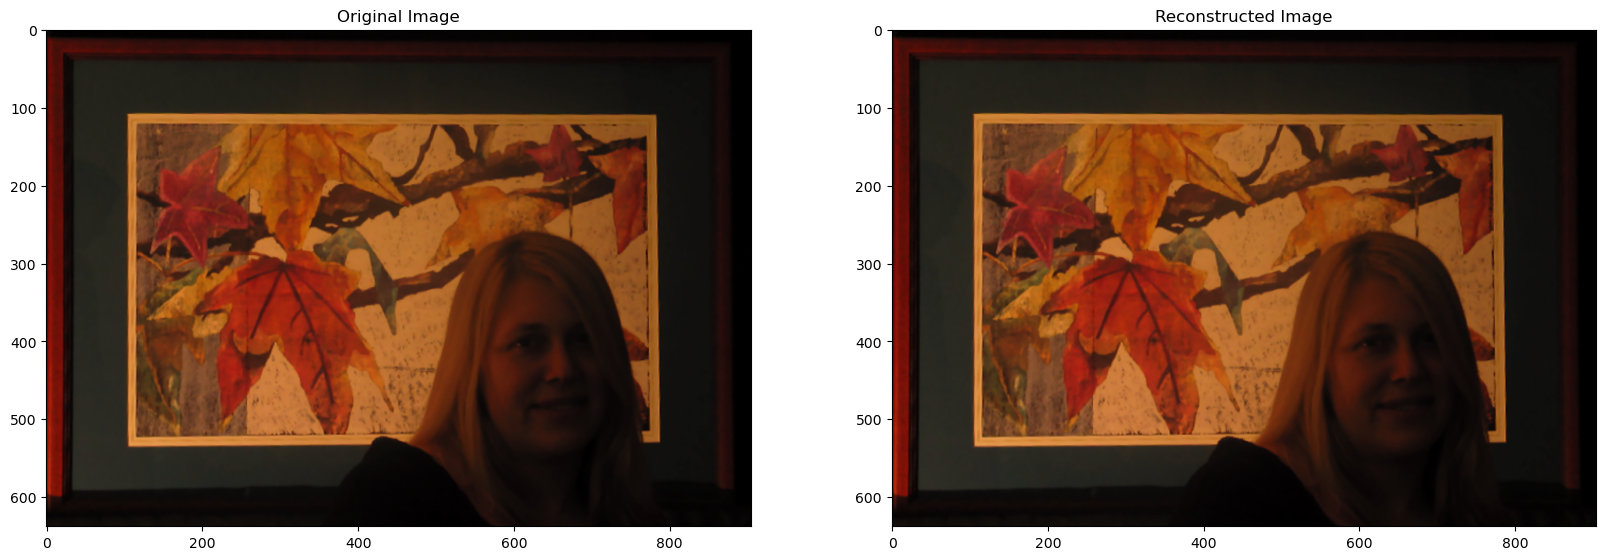

In [112]:
fig, ax = plt.subplots(2, figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(img_museum_amb_norm)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(I_star)
plt.title("Reconstructed Image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.015993511018881912


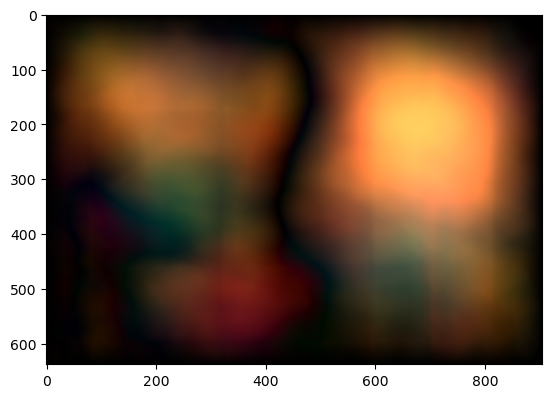

In [113]:
img_diff = np.abs(img_museum_amb_norm - I_star)
# img_diff_base = (img_diff_base - np.min(img_diff_base))/(np.max(img_diff_base) - np.min(img_diff_base))

print(img_diff.min(), img_diff.max())
plt.imshow(100*img_diff)

## Create the fused gradient field

In [114]:
def fuse_gradient_field(img_amb_norm, img_flash_norm, sigma, tau_s) : 
    """
    Create a fused gradient field from ambient and flash images.
    """    
    a_x, a_y = compute_gradient(img_amb_norm)
    phi_dash_x, phi_dash_y = compute_gradient(img_flash_norm)
    
    a_x_org = a_x.copy()
    a_y_org = a_y.copy()
    
    a_x, phi_dash_x = a_x[1:,:], phi_dash_x[1:,:]
    a_y, phi_dash_y = a_y[:,1:], phi_dash_y[:,1:]
    
    M_num = phi_dash_x * a_x + phi_dash_y * a_y
    M_den = np.sqrt(phi_dash_x**2 + phi_dash_y**2) * np.sqrt(a_x**2 + a_y**2)
    M = M_num / (M_den+0.00001)

    ws = np.zeros(a_x.shape)
    ws[:-1,:-1] = np.tanh(sigma * (img_flash_norm-tau_s))
    ws = (ws - np.min(ws)) / (np.max(ws) - np.min(ws))

    phi_star_x = np.zeros(a_x_org.shape)
    phi_star_y = np.zeros(a_y_org.shape)
    phi_star_x[1:,:] = ws * a_x + (1-ws) * (M * phi_dash_x + (1-M) * a_x)
    phi_star_y[:,1:] = ws * a_y + (1-ws) * (M * phi_dash_y + (1-M) * a_y)

    return phi_star_x, phi_star_y

sigma = 40
tau = 0.8

phi_star_x, phi_star_y = fuse_gradient_field(img_museum_amb_norm[:,:,0], img_museum_flash_norm[:,:,0], sigma, tau)

phi_star_x_3channel_list = []
phi_star_y_3channel_list = []
div_phi_star = np.zeros_like(img_museum_amb_norm)
for channel in range(3) :
    phi_star_x, phi_star_y = fuse_gradient_field(img_museum_amb_norm[:,:,channel], img_museum_flash_norm[:,:,channel], sigma, tau)    
    div_phi_star[:, :, channel] = compute_div(phi_star_x, phi_star_y)
    
    phi_star_x_3channel_list.append(phi_star_x)
    phi_star_y_3channel_list.append(phi_star_y)

# I_star = np.zeros_like(img_museum_amb_norm)
# for channel in range(3) :
#     I_star[:,:,channel] = poisson_solver(div_phi_star[:,:,channel], img_museum_amb_norm[:,:,channel], N=5000, eps=0.0001)

I_star = np.zeros_like(img_museum_flash_norm)
for channel in range(3) :
    I_star[:,:,channel] = poisson_solver(div_phi_star[:,:,channel], img_museum_flash_norm[:,:,channel], N=5000, eps=0.0001)


Number of iterations =  1497
Final error =  9.98477859394109e-05
Number of iterations =  1558
Final error =  9.890829505895924e-05
Number of iterations =  1436
Final error =  9.93762274993791e-05


In [115]:
I_star = np.zeros_like(img_museum_flash_norm)
for channel in range(3) :
    I_star[:,:,channel] = poisson_solver(div_phi_star[:,:,channel], img_museum_flash_norm[:,:,channel], N=5000, eps=0.0001)


Number of iterations =  1497
Final error =  9.98477859394109e-05
Number of iterations =  1558
Final error =  9.890829505895924e-05
Number of iterations =  1436
Final error =  9.93762274993791e-05


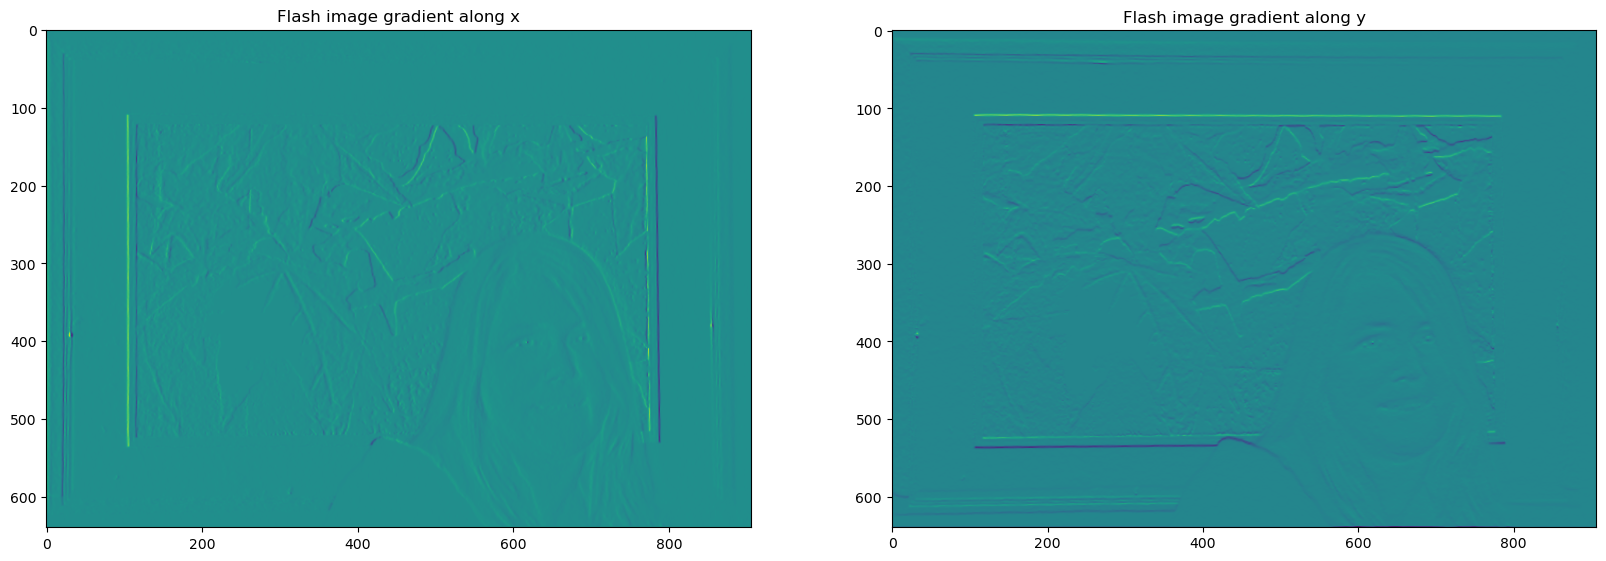

In [116]:
phi_dash_x, phi_dash_y = compute_gradient(img_museum_flash_norm[:,:,0])

fig, ax = plt.subplots(2, figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(phi_dash_x)
plt.title("Flash image gradient along x")

plt.subplot(1,2,2)
plt.imshow(phi_dash_y)
plt.title("Flash image gradient along y")

plt.show()


In [121]:
plt.imsave('./outputs/phi_dash_x.png',phi_dash_x)
plt.imsave('./outputs/phi_dash_y.png',phi_dash_y)

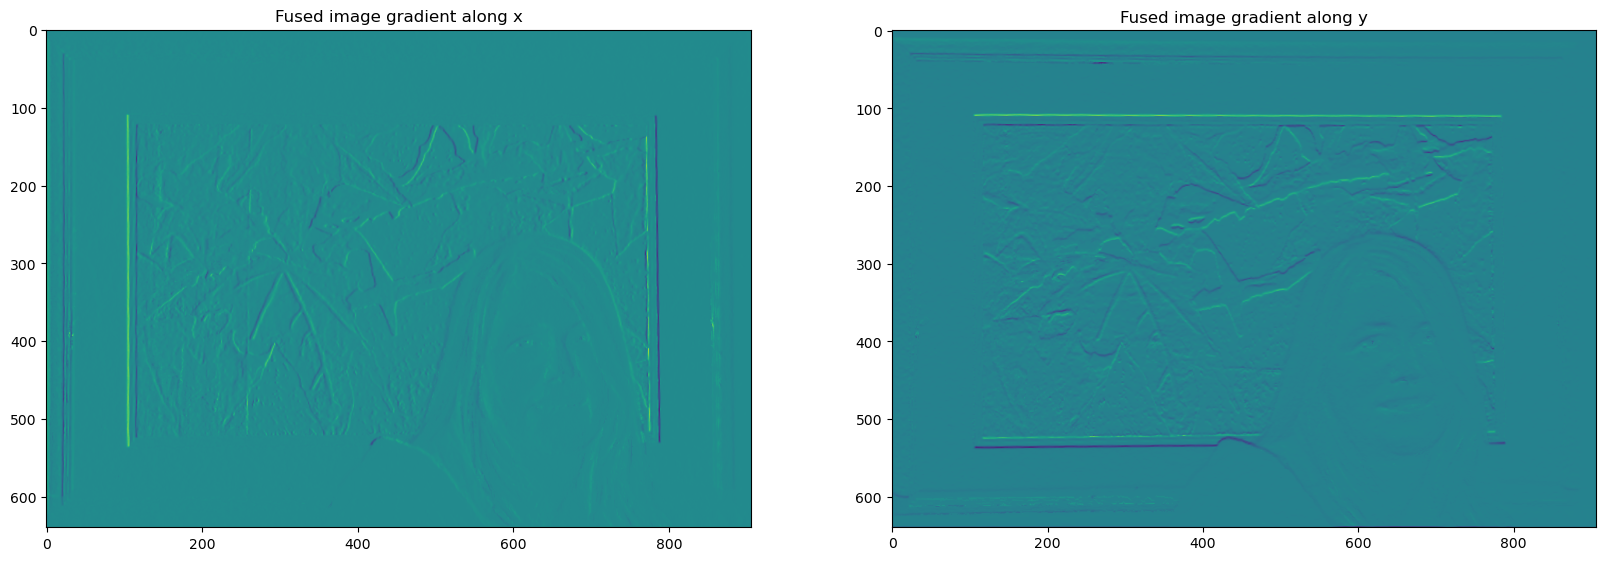

In [117]:
phi_star_x = phi_star_x_3channel_list[0]
phi_star_y = phi_star_y_3channel_list[0]

fig, ax = plt.subplots(2, figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(phi_star_x)
plt.title("Fused image gradient along x")

plt.subplot(1,2,2)
plt.imshow(phi_star_y)
plt.title("Fused image gradient along y")

plt.show()


In [122]:
plt.imsave('./outputs/phi_star_x.png',phi_star_x)
plt.imsave('./outputs/phi_star_y.png',phi_star_y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image')

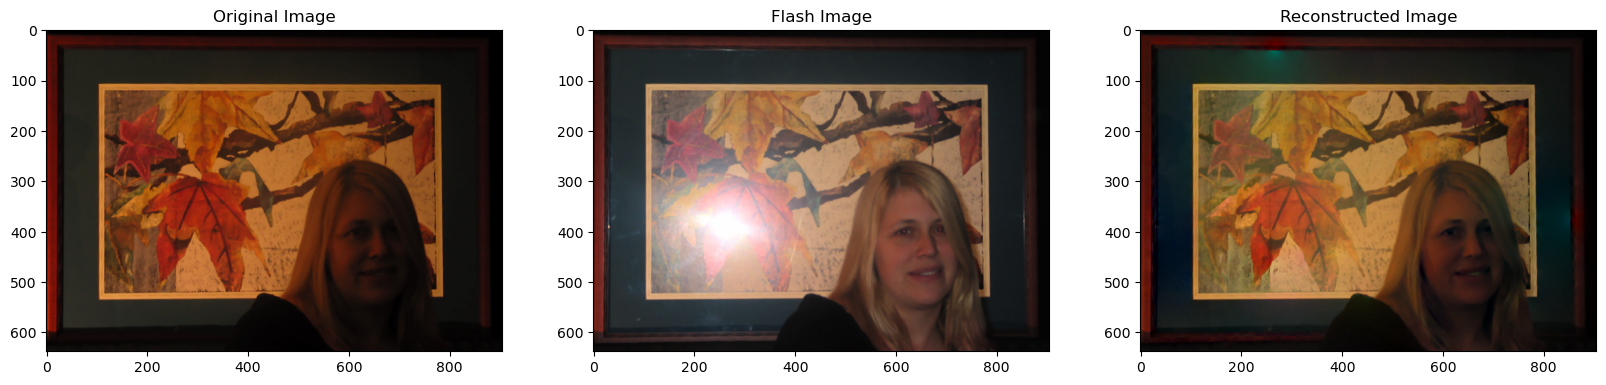

In [118]:
fig, ax = plt.subplots(3, figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(img_museum_amb_norm)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(img_museum_flash_norm)
plt.title("Flash Image")

plt.subplot(1,3,3)
plt.imshow(I_star)
plt.title("Reconstructed Image")


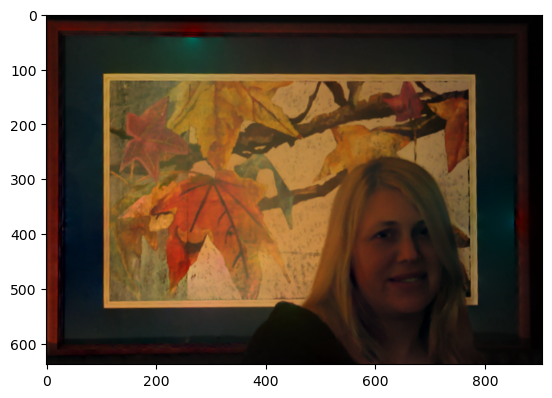

In [123]:
plt.imshow(np.clip(I_star,0,1))
plt.imsave('./outputs/I_star.png',np.clip(I_star,0,1))